<a href="https://colab.research.google.com/github/Brijeshtanwar/Topic-Modeling/blob/main/sklearn_nlp_fasttext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# NLP libraries
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/voc_data.csv"""
df = pd.read_csv(url,  encoding = 'unicode_escape')

In [4]:
df = df[['CUSTOMER COMMENT', 'Reason']]
df.columns = ['comment', 'topic']

In [5]:
df.isnull().sum()

comment    0
topic      0
dtype: int64

In [6]:
# Drop na
df.dropna(axis=0, inplace=True)

In [7]:
df.topic.value_counts()

Service                      1570
APPLICATION (WEB/APP)        1074
SERVICE                       335
CHARGES(BRO./DP/LPC ETC.)     332
Others                        321
NOT SPECIFIED                 254
Not Specified                 216
People                        113
Process                        69
PEOPLE                         32
Product                        13
PROCESS                         6
Name: topic, dtype: int64

In [8]:
#lower case
df['topic'] = df['topic'].str.lower()
df['topic'] = df['topic'].str.strip()
df.loc[df.topic=='not specified', 'topic'] = 'others'

In [9]:
df.topic.unique()

array(['service', 'application (web/app)', 'others',
       'charges(bro./dp/lpc etc.)', 'process', 'people', 'product'],
      dtype=object)

In [10]:
topic_dic = {'application (web/app)': 'application',  'charges(bro./dp/lpc etc.)': 'charges', 'service':'service'
, 'others':'others', 'process':'process', 'people':'people', 'product':'product'}

In [11]:
df['topic'] = df['topic'].map(topic_dic)

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='count', ylabel='topic'>

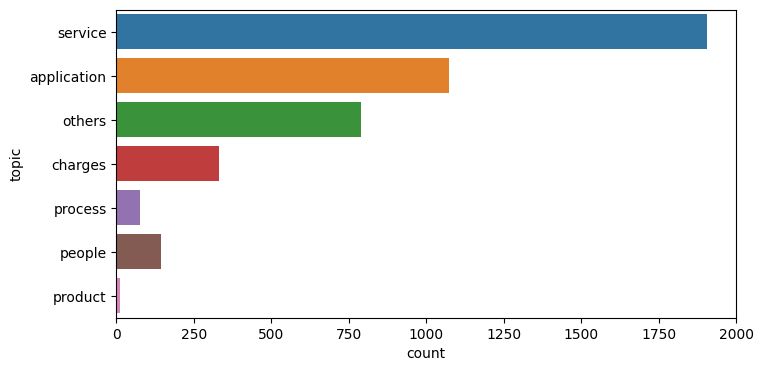

In [12]:
plt.figure(figsize=[8,4])
sns.countplot(y=df['topic'])

In [13]:
# Preprocessing

In [14]:
# Remove integer comments
df = df[df['comment'].apply(lambda x: not isinstance(x, int))]
df.reset_index(drop=True, inplace=True)

#lower case
df['comment'] = df['comment'].str.lower()

In [15]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and  characters and then strip)
    text = re.sub(r"[^A-Za-z]+", ' ' , str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    # if lst_stopwords is not None:
    #     lst_text = [word for word in lst_text if word not in lst_stopwords]

    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [16]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords.remove('no')
lst_stopwords.remove('not')

In [17]:
df["x"] = df["comment"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=False, lst_stopwords=lst_stopwords))
# df['x'] = df['comment']
df['y'] = df['topic']
df.head(10)

,comment,topic,x,y
0,querries where kotak is at disadvantageous pos...,service,querries where kotak is at disadvantageous pos...,service
1,1) same-day money deduction even if we have ma...,application,same day money deduction even if we have margi...,application
2,ndejjejdjx,others,ndejjejdjx,others
3,worst website trading,application,worst website trading,application
4,"no technical support at real time, application...",service,no technical support at real time application ...,service
5,need knowledge and experience person,service,need knowledge and experience person,service
6,please revisit my brokerage and deemat charges...,charges,please revisit my brokerage and deemat charges...,charges
7,iâm waiting for resolution or a meeting with...,service,i m waiting for resolution or a meeting with m...,service
8,i dint interacted so my rating may be a bias b...,service,i dint interacted so my rating may be a bias b...,service
9,no issues with the rm,service,no issues with the rm,service


In [18]:
df = df[['x', 'y']]

In [19]:
# Prefixing each row of the category column with '__label__'
df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: '__label__' + x)

In [20]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.10, stratify=df['y'], random_state=324)

In [21]:
import csv

In [22]:
pip install fasttext


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393396 sha256=8e4822595735c5c096c81148d1d4aa3f3c80ebcae2e2bd209218488876ad6eb2
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [23]:
import fasttext
# Saving the CSV file as a text file to train/test the classifier
df_train[['y', 'x']].to_csv('train.txt',
                                          index = False,
                                          sep = ' ',
                                          header = None,
                                          quoting = csv.QUOTE_NONE,
                                          quotechar = "",
                                          escapechar = " ")

df_test[['y', 'x']].to_csv('test.txt',
                                     index = False,
                                     sep = ' ',
                                     header = None,
                                     quoting = csv.QUOTE_NONE,
                                     quotechar = "",
                                     escapechar = " ")


# Training the fastText classifier
model = fasttext.train_supervised('train.txt',lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50)

# Evaluating performance on the entire test file
model.test('test.txt')

# Predicting on a single input
# model.predict(ds.iloc[2, 0])

# Save the trained model
#model.save_model('model.bin')

(434, 0.8571428571428571, 0.8571428571428571)

In [24]:
model.test('train.txt')

(3901, 0.9997436554729556, 0.9997436554729556)

In [25]:
df_test_pred = df_test
df_test_pred['y_pred'] = df_test_pred['x'].apply(model.predict)
df_test_pred['y_pred']=df_test_pred['y_pred'].str[0:1]
df_test_pred['y_pred'] = df_test_pred['y_pred'].astype(str)
df_test_pred['y_pred'] = df_test_pred['y_pred'].str[12:-5]
df_test_pred['y'] = df_test_pred['y'].str[9:]

In [26]:
df_pred = df
df_pred['y_pred'] = df_pred['x'].apply(model.predict)
df_pred['y_pred'] = df_pred['y_pred'].str[0:1]
df_pred['y_pred'] = df_pred['y_pred'].astype(str)
df_pred['y_pred'] = df_pred['y_pred'].str[12:-5]
df_pred['y'] = df_pred['y'].str[9:]

In [27]:
df

,x,y,y_pred
0,querries where kotak is at disadvantageous pos...,service,service
1,same day money deduction even if we have margi...,application,application
2,ndejjejdjx,others,others
3,worst website trading,application,application
4,no technical support at real time application ...,service,service
...,...,...,...
4330,please reduce my brokerage in my equity accoun...,charges,charges
4331,its waste to call with out resolving the issues,service,service
4332,use less service nnnnnnnnmf d d d d d d d d d d,service,service
4333,sunil,others,others


In [28]:
# Dict for classes
df_pred['category_id'] = df_pred['y'].factorize()[0]
category_id_df = df_pred[['y', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'y']].values)

In [29]:
df_test_pred['category_id'] = df_test_pred['y'].map(category_to_id)
df_test_pred['category_id_pred'] = df_test_pred['y_pred'].map(category_to_id)
df_pred['category_id_pred'] = df_pred['y_pred'].map(category_to_id)

In [30]:
df_test_pred[df_test_pred['category_id_pred'].isnull()]

,x,y,y_pred,category_id,category_id_pred


In [31]:
df_test_pred.y_pred.unique()

array(['others', 'service', 'application', 'people', 'charges', 'process'],
      dtype=object)

<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

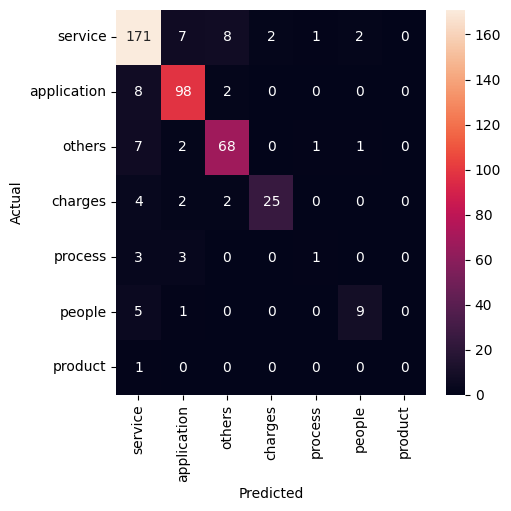

In [32]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_test_pred['category_id'], df_test_pred['category_id_pred'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [33]:
# Classification report
from sklearn import metrics
print(metrics.classification_report(df_test_pred['category_id'], df_test_pred['category_id_pred'], target_names=df['y'].unique()))

              precision    recall  f1-score   support

     service       0.86      0.90      0.88       191
 application       0.87      0.91      0.89       108
      others       0.85      0.86      0.86        79
     charges       0.93      0.76      0.83        33
     process       0.33      0.14      0.20         7
      people       0.75      0.60      0.67        15
     product       0.00      0.00      0.00         1

    accuracy                           0.86       434
   macro avg       0.66      0.59      0.62       434
weighted avg       0.85      0.86      0.85       434



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

Text(33.222222222222214, 0.5, 'Actual')

Text(0.5, 25.722222222222214, 'Predicted')

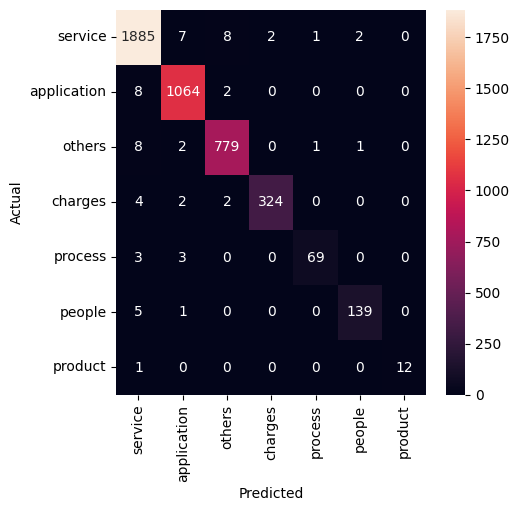

In [34]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_pred['category_id'], df_pred['category_id_pred'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [35]:
# Classification report overall
from sklearn import metrics
print(metrics.classification_report(df_pred['category_id'], df_pred['category_id_pred'], target_names=df['y'].unique()))

              precision    recall  f1-score   support

     service       0.98      0.99      0.99      1905
 application       0.99      0.99      0.99      1074
      others       0.98      0.98      0.98       791
     charges       0.99      0.98      0.98       332
     process       0.97      0.92      0.95        75
      people       0.98      0.96      0.97       145
     product       1.00      0.92      0.96        13

    accuracy                           0.99      4335
   macro avg       0.99      0.96      0.97      4335
weighted avg       0.99      0.99      0.99      4335



In [36]:
res = pd.DataFrame()
# To manually verify why some failed
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            # print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            temp = df_pred.query(f' (category_id == {actual}) & (category_id_pred == {predicted})')[['x']]
            temp['y'] = id_to_category[actual]
            temp['y_pred'] = id_to_category[predicted]
            # print('')
            res = pd.concat([res,temp])

In [37]:
from google.colab import data_table
data_table.DataTable(res, include_index=False, num_rows_per_page=10)

""


In [38]:
from google.colab import data_table
data_table.DataTable(df_pred.query(' y != y_pred')[['x','y', 'y_pred']], include_index=False, num_rows_per_page=10)

,x,y,y_pred
900,useless and unfriendly,service,others
945,your research is eating money of your membersf...,others,service
967,reduce charge and improve customer support,service,people
1131,pls pravide quality cc,service,others
1184,bad experience for a years old customer,others,service
...,...,...,...
4231,have talked to people in a day and had differe...,people,service
4268,expect someone from ks to guide me on the usag...,service,application
4269,toll free numbers are not answering many time ...,people,service
4289,charges are high app is not slick,charges,application


In [39]:
# Testing on Apr May data

In [40]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/test_data.csv"""
test = pd.read_csv(url,  encoding = 'unicode_escape')

In [41]:
test.columns = ['comment', 'topic']

In [42]:
test['topic'].unique()

array(['People', 'WEB/APP', 'not specified', 'Charges', 'product',
       'Service', 'process', 'others', 'reasearch', 'OTHERS'],
      dtype=object)

In [43]:
topic_dic = {'WEB/APP': 'application',  'Charges': 'charges', 'Service':'service'
, 'OTHERS':'others', 'not specified':'others', 'process':'process', 'People':'people', 'product':'product', 'reasearch':'research'}

In [44]:
test['topic'] = test['topic'].map(topic_dic)

In [45]:
test.head()

,comment,topic
0,"0 is very high, it should be negative as ur s...",people
1,1. Website is quite slow- must be improved. 2...,application
2,1.Order execution refresh rate is slow. Improv...,application
3,3 rd clasd,others
4,3 rd class,others


In [46]:
test["x"] = test["comment"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=False, lst_stopwords=lst_stopwords))
# df['x'] = df['comment']
test['y'] = test['topic']
test.head(10)

,comment,topic,x,y
0,"0 is very high, it should be negative as ur s...",people,is very high it should be negative as ur staff...,people
1,1. Website is quite slow- must be improved. 2...,application,website is quite slow must be improved a watch...,application
2,1.Order execution refresh rate is slow. Improv...,application,order execution refresh rate is slow improveme...,application
3,3 rd clasd,others,rd clasd,others
4,3 rd class,others,rd class,others
5,à¤®à¥à¤¨à¥ à¤¡à¥à¤²à¤° à¤¸à¥ à¤à¤¾à¤à¤à...,others,,others
6,About brokerage,charges,about brokerage,charges
7,Active BSE FO,product,active bse fo,product
8,Actually aap is not properly work and delar di...,application,actually aap is not properly work and delar di...,application
9,Add order execution notification sound,application,add order execution notification sound,application


In [47]:
# Remove integer comments
test = test[test['x'].apply(lambda x: not isinstance(x, int))]
test.reset_index(drop=True, inplace=True)

#lower case
test['x'] = test['x'].str.lower()

In [48]:
test['y_pred'] = test['x'].apply(model.predict)
test['y_pred']=test['y_pred'].str[0:1]
test['y_pred'] = test['y_pred'].astype(str)
test['y_pred'] = test['y_pred'].str[12:-5]
test['y'] = test['y'].str[9:]

In [52]:
test.dropna(inplace=True)

In [54]:
# Classification report overall
from sklearn import metrics
print(metrics.classification_report(test['topic'], test['y_pred'], target_names=test['topic'].unique().sort()))

              precision    recall  f1-score   support

 application       0.80      0.70      0.75       190
     charges       0.83      0.81      0.82        47
      others       0.84      0.58      0.69       188
      people       0.50      0.11      0.18        37
     process       0.00      0.00      0.00         4
     product       0.00      0.00      0.00        20
    research       0.00      0.00      0.00         3
     service       0.38      0.88      0.53       105

    accuracy                           0.63       594
   macro avg       0.42      0.38      0.37       594
weighted avg       0.69      0.63      0.63       594



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test['y_pred'].value_counts()

service        237
application    169
others         130
charges         45
people           7
process          6
Name: y_pred, dtype: int64

In [ ]:
test['topic'].value_counts()


application    190
others         188
service        105
charges         47
people          37
product         20
process          4
research         3
Name: topic, dtype: int64